Overview: Pixelizations
-----------------------

Pixelizations reconstruct the source galaxy's light on a pixel-grid. Unlike `LightProfile`'s, they are able to
reconstruct the light of non-symmetric, irregular and clumpy sources.

To reconstruct the source using a `Pixelization`, we have to impose a prior on the smoothness of the reconstructed
source, called the `Regularization`. The more we regularize the source, the smoother the source reconstruction.

The process of reconstructing a `Galaxy`'s light using a `Pixelization` and `Regularization` is called an `Inversion`,
and the term `inversion` is used throughout the **PyAutoLens** example scripts to signify that their source analysis
reconstructs its light on a pixel-grid.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Load the `Imaging` data that we'll reconstruct the lensed source galaxy's light of using a pixelization.

Note how complex the lensed source galaxy looks, with multiple clumps of light - this would be very difficult to 
represent using `LightProfile`'s!

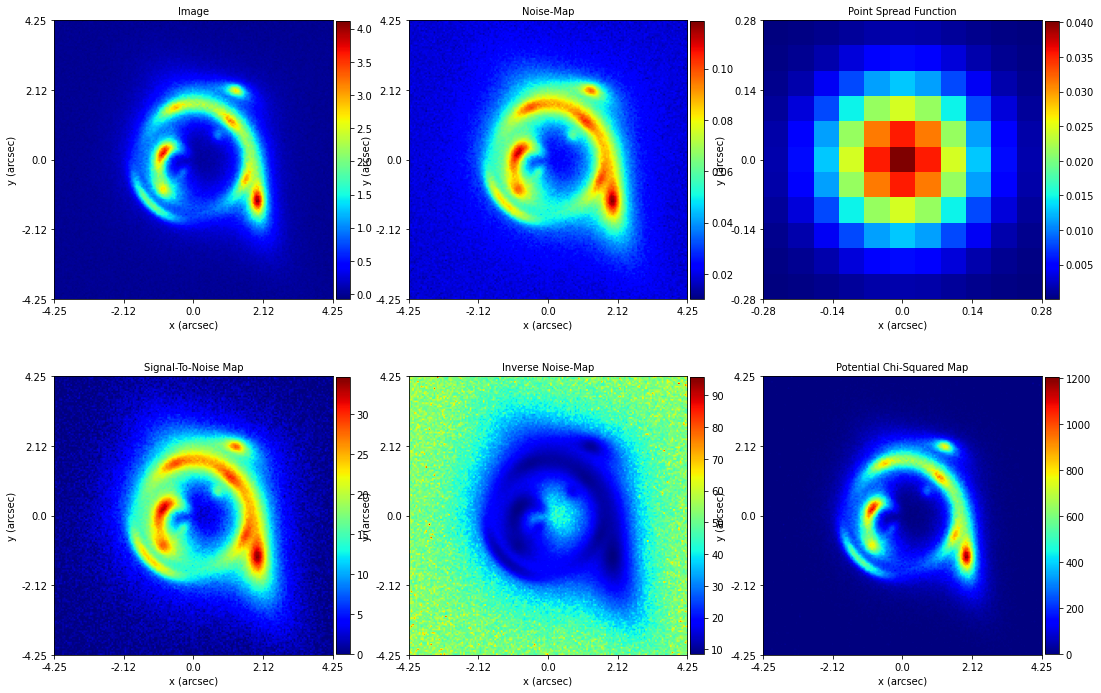

In [2]:
dataset_name = "mass_sie__source_sersic_x4"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.05,
)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

We are going to fit this data, so we must create `Mask2D` and `MaskedImaging` objects.

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=1,
    radius=3.6,
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

To reconstruct the source as a `Pixelization`, we simply pass it the `Pixelization` class we want to reconstruct its l
ight on as well as the `Regularization` scheme describing how we smooth the source reconstruction. 

First, lets use a *Rectangular* `Pixelization` with resolution 40 x 40 and *Constant* regularizaton scheme with a 
relatitvely high regularization-coefficient. The higher this coefficient, the more our source reconstruction will be
smoothed.

The lens galaxy's `EllipticalIsothermal` mass model is the true model used to simulate the data.

In [4]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

Now that our source-galaxy has a `Pixelization` and `Regularization`, we are able to fit the data using these in the 
same way as before, by simply passing the source galaxy to a `Tracer` and using this `Tracer` to create a `FitImaging`
object.

In [5]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 673:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


The fit has been performed using an `Inversion` for the source galaxy. We can see this by plotting the source-plane
of the `FitImaging` using the `subplot_of_plane` mat_plot_2d. Note how the bottom-right panel shows a pixelized grid.

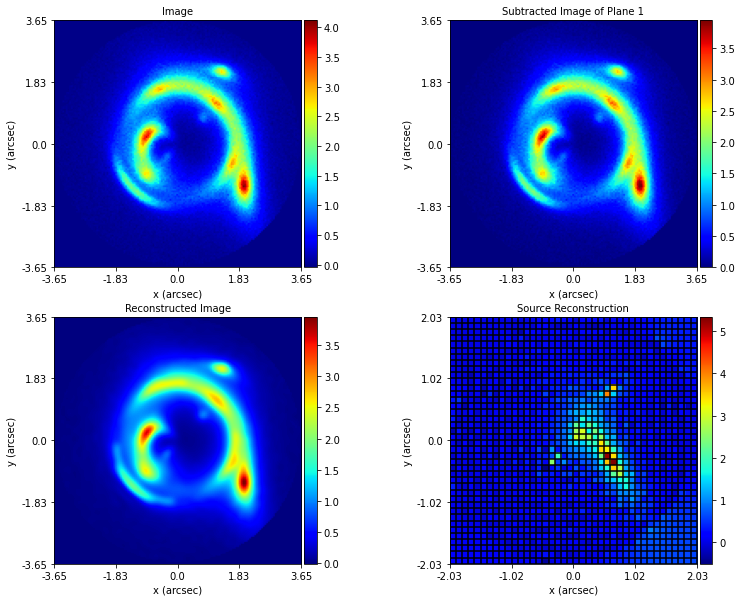

In [6]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
fit_imaging_plotter.subplot_of_planes(plane_index=1)

**PyAutoLens** supports many different pixel-grids. Below, we use a *VoronoiMagnification* pixelization, which defines
the source-pixel centres in the image-plane and ray traces them to the source-plane. 

The source pixel-grid is therefore adapted to the mass-model magnification pattern, placing more source-pixel in the
highly magnified regions of the source-plane.

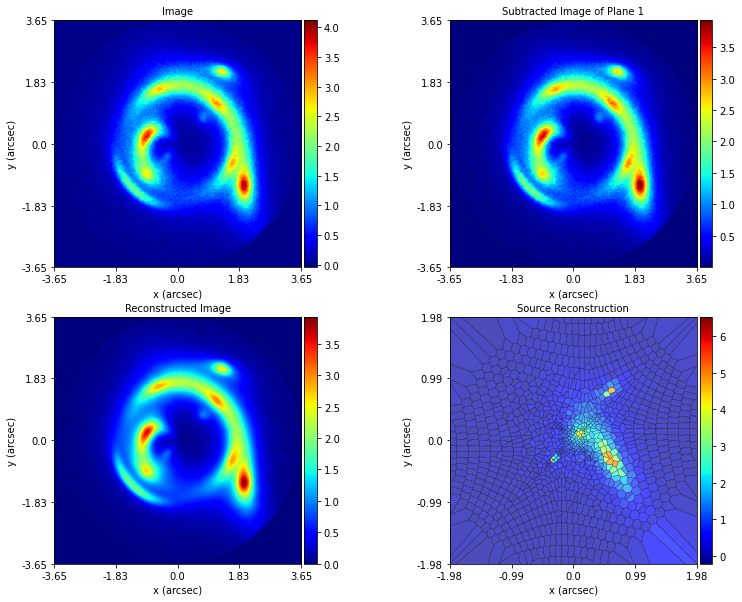

In [7]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
fit_imaging_plotter.subplot_of_planes(plane_index=1)

By inspecting the residual-map, normalized residual-map and chi-squared-map of the `FitImaging` object, we can see how
the source reconstruction accurately fits the image of the strong lens:

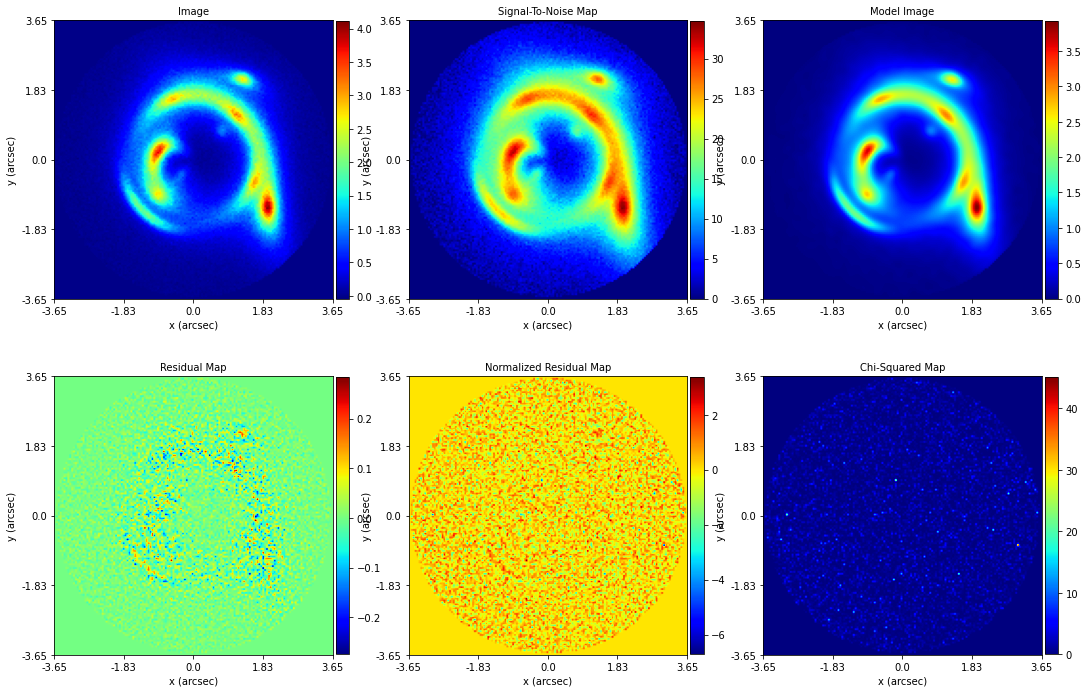

In [8]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
fit_imaging_plotter.subplot_fit_imaging()

This script has given a brief overview of *Inversions* with **PyAutoLens**. However, there is a lot more to using
*Inversions* then presented here. 

In the `autolens_workspace/notebooks/modeling/inversion` folder you will find example scripts of how to fit a model to a 
strong lens using an `Inversion`. In chapters 4 and 5 of the **HowToLens** lectures we fully cover all details of  
*Inversions*, specifically:

 - How the source reconstruction determines the flux-values of the source it reconstructs.
 - The Bayesian framework employed to choose the appropriate level of `Regularization` and avoid overfitting noise.
 - Unphysical lens model solutions that often arise when using an `Inversion`.
 - Advanced `Pixelization` and `Regularization` schemes that adapt to the source galaxy being reconstructed.